In [1]:
%matplotlib inline 
import os
import random
import pandas_datareader.data as web
import yfinance as yf
import pandas as pd
import datetime
import numpy as np
from ipywidgets import interact, fixed, IntSlider
import matplotlib.pyplot as plt
from numpy.linalg import cholesky
import seaborn as sns


C:\Users\User\miniconda3\envs\tensorflow\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
cached_data={}
def stock_hist(symbol, start=None, end=None, cached_data=cached_data):
    '''Convenience function to get cached data '''
    if not symbol in cached_data:
        cached_data[symbol] = yf.download(symbol)
        print(F'Loaded {symbol} num values = {len(cached_data[symbol])}')
    return cached_data[symbol]

In [3]:
tickers = ['MSFT', 'AMZN','GOOG','SQ','LOW','GLD']
N = len(tickers)
historical  = pd.concat((stock_hist(symbol)['Adj Close'] for symbol in tickers), axis=1, keys=tickers).dropna(axis=0)

[*********************100%***********************]  1 of 1 completed
Loaded MSFT num values = 8702
[*********************100%***********************]  1 of 1 completed
Loaded AMZN num values = 5876
[*********************100%***********************]  1 of 1 completed
Loaded GOOG num values = 4050
[*********************100%***********************]  1 of 1 completed
Loaded SQ num values = 1216
[*********************100%***********************]  1 of 1 completed
Loaded LOW num values = 10216
[*********************100%***********************]  1 of 1 completed
Loaded GLD num values = 3986


In [4]:
# _ = (historical).plot(figsize=(20,10),title='Stocks Price over time')
# historical.head(2)

In [5]:
returns = (historical/historical.iloc[0]).fillna(method='backfill')
daily_pct_change = np.log(returns.pct_change() + 1)
vols = daily_pct_change.std() * np.sqrt(252)



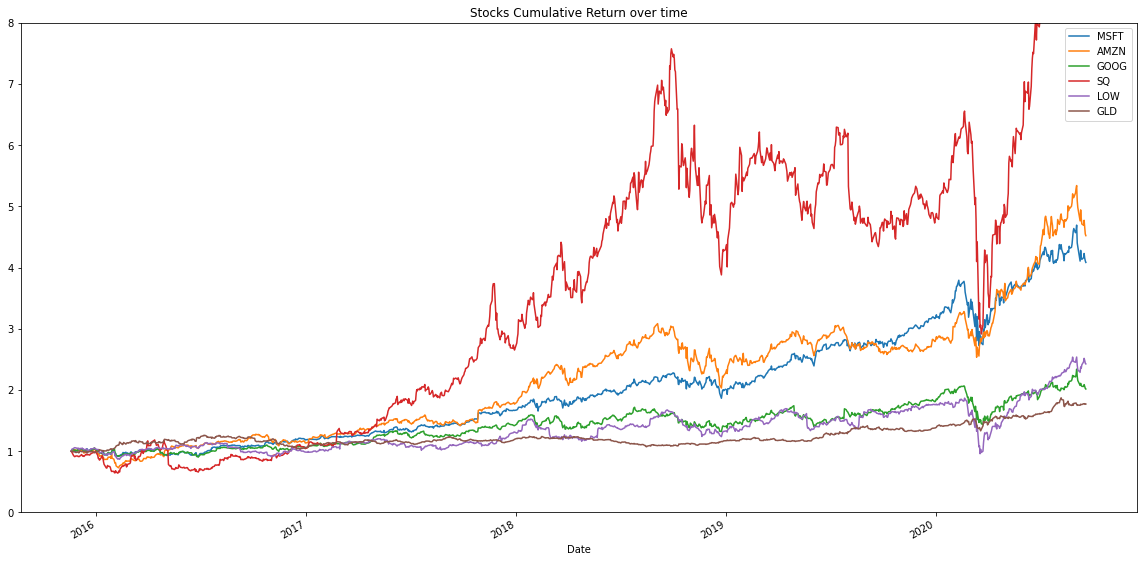

In [6]:
_ = returns.plot(ylim=(0,8), figsize=(20,10),title='Stocks Cumulative Return over time')

In [7]:
returns['PORTFOLIO'] = returns.iloc[:,0:N].sum(axis=1) /N

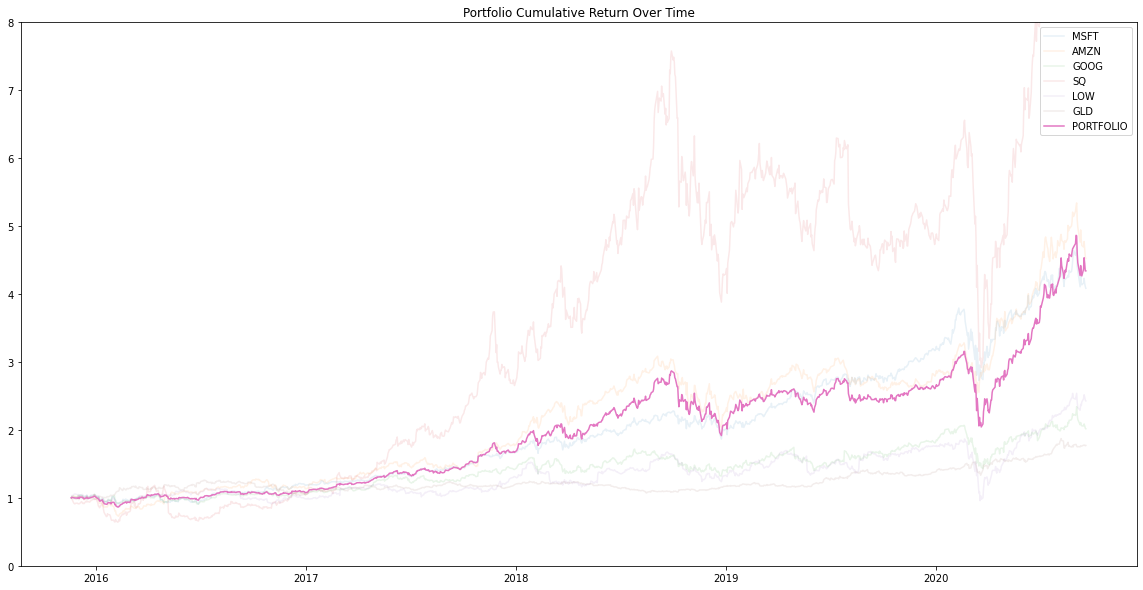

In [8]:
plt.figure(figsize=(20,10))
lines = plt.plot(returns.drop('PORTFOLIO', axis=1), alpha=0.1)
plt.ylim((0,8))
plt.title('Portfolio Cumulative Return Over Time')
plt.plot(returns['PORTFOLIO'], alpha=1)
plt.legend(returns.columns)
plt.show()


In [9]:
daily_pct_change = np.log(returns.pct_change() + 1)
vols = daily_pct_change.std() * np.sqrt(252) # Annual Volatility 

tickers=['AAPL', 'TSLA', 'FB','IBM', 'GOOG']
prices = [stock_hist(symbol)['Adj Close'] for symbol in tickers]
prices = pd.concat((stock_hist(symbol)['Adj Close'] for symbol in tickers), axis=1, keys=tickers).dropna(axis=0)
prices.head(2)

[*********************100%***********************]  1 of 1 completed
Loaded AAPL num values = 10027
[*********************100%***********************]  1 of 1 completed
Loaded TSLA num values = 2575
[*********************100%***********************]  1 of 1 completed
Loaded FB num values = 2098
[*********************100%***********************]  1 of 1 completed
Loaded IBM num values = 14781


,AAPL,TSLA,FB,IBM,GOOG
Date,,,,,
2012-05-18,16.368652,5.512,38.230000,144.467072,299.078979
2012-05-21,17.322281,5.754,34.029999,145.853592,305.908386


In [10]:
def diversicheck(symbols, start_day=0, time_horizon=365, **active):
    filtered = [symbol for symbol in symbols if active.get(symbol, True)]
    prices = pd.concat((stock_hist(symbol)['Adj Close'] for symbol in filtered), axis=1, keys=filtered).dropna(axis=0)
    
    
    start_dates = prices.index[0] + datetime.timedelta(days = start_day)
    end_dates = start_dates + datetime.timedelta(days=time_horizon)
    
    prices = prices.loc[start_dates:end_dates]
    
    unit_pos = prices / prices.iloc[0,:]
    basket = unit_pos.sum(axis=1) / unit_pos.shape[1]
    unit_pos.plot(figsize=(20,10),title='Stocks Cumulative Return over time', alpha=0.3)
    basket.plot(figsize=(20,10),legend = True)
    print(f'backtest from {start_dates} to {end_dates}')


In [11]:
# cached_data ={}
prf_stocks = ['SPY','AAPL', 'TSLA', 'FB','IBM', 'GOOG']
active = dict(zip(prf_stocks, [True] * len(prf_stocks)))
_ = interact(diversicheck, symbols =fixed(prf_stocks), start_day=IntSlider(min=0,max=252*10),
             time_horizon=IntSlider(min=0,value=365,max=252*5),**active)

interactive(children=(IntSlider(value=0, description='start_day', max=2520), IntSlider(value=365, description=…

In [12]:
prf_prices = pd.concat((stock_hist(symbol)['Adj Close'] for symbol in prf_stocks), axis =1, keys=prf_stocks).dropna(axis=0)
prf_returns = (prf_prices.pct_change() + 1)[1:]
log_returns = np.log(prf_returns)
corr = log_returns.corr()


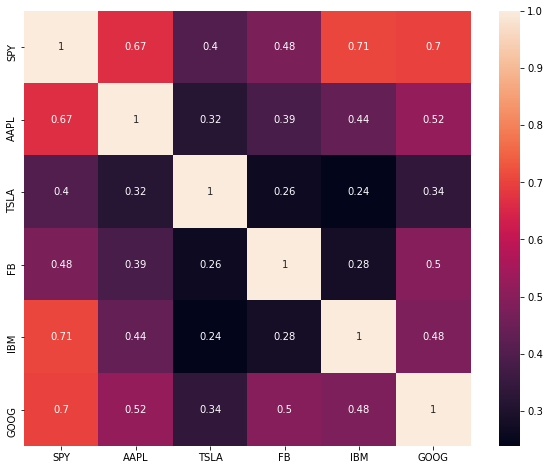

In [13]:
fig, ax = plt.subplots(figsize=(10,8)) 
sns.heatmap(corr, annot=True)

In [14]:
vols = log_returns.std() * np.sqrt(252)
avg_return = (prf_returns-1).mean()

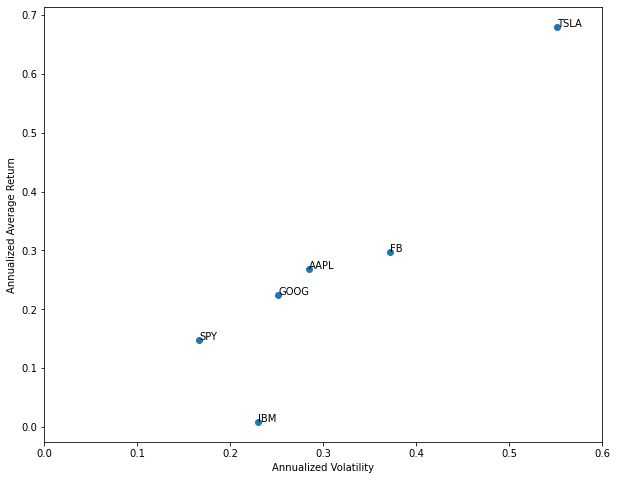

In [15]:
fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(vols, avg_return*252)
ax.set_xlabel('Annualized Volatility')
ax.set_ylabel('Annualized Average Return')
ax.set_xlim(0,0.6)
for i, txt in enumerate(prf_stocks):
    ax.annotate(txt, xy=(vols[i], avg_return[i]*252))

In [16]:
number_of_simulations = 1000
investment_horizon = 60
simulated = pd.DataFrame([(prf_returns.iloc[random.choices(
    range(len(prf_returns)), k=investment_horizon)]).mean(axis=1).cumprod().values 
                         for x in range(number_of_simulations)]).T
simulated.head(3)

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0.978904,1.011738,0.966503,1.010188,1.013543,0.996944,1.025923,0.993611,1.007345,1.008847,...,0.987456,0.984445,1.007234,1.011398,0.998544,0.990898,0.987554,0.997186,0.993130,1.003945
1,0.974361,1.018724,0.948649,1.016877,1.035829,1.006666,1.028054,1.000761,1.001869,1.026534,...,0.984159,0.999673,1.012611,1.023158,0.989098,1.006248,0.989221,1.018800,0.993996,1.013751
2,0.984232,0.994084,0.952282,0.999557,1.060795,1.026882,1.049455,0.997996,1.009387,1.019308,...,0.982506,0.994873,1.031960,1.024920,0.999887,1.006990,0.986864,1.006943,1.003463,1.006801


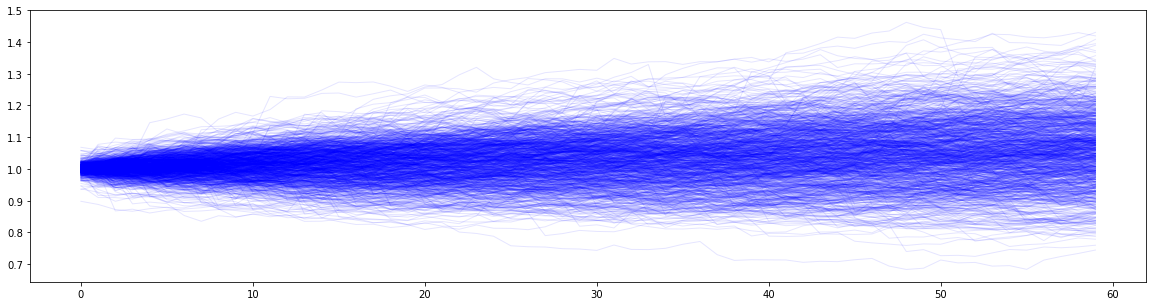

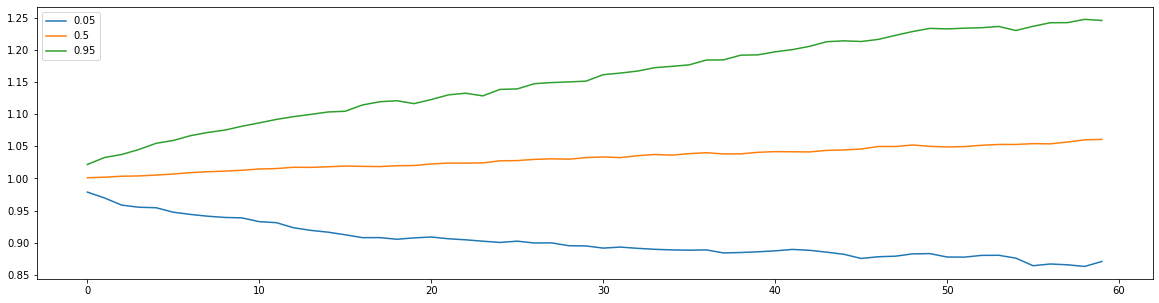

In [17]:
simulated.plot(legend=False, linewidth=1, alpha=0.1, color='blue', figsize=(20,5))
simulated.quantile([0.05, 0.50, 0.95], axis=1).T.plot(figsize=(20,5))

In [19]:
simulated.to_csv('testing1.csv', index=0) # Save Result